# **Tanzanian Water Wells Prediction**

---


### **Authors:** [Abduba Galgalo](https://github.com/Abduba011), [Faith Makokha](https://github.com/faithmaks), [Femi Kamau](https://github.com/ctrl-Karugu), [John Mungai](https://github.com/Johnspes), [Susan Mungai](https://github.com/SueMungai), and [Willy Angole](https://github.com/Willy-Angole)

## 1. Business Understanding

## 2. Data Understanding

> This phase is broken down into four tasks together with its projected outcome or output in detail:
> - Collect Initial Data
> - Describe Data
> - Explore Data
> - Verify Data Quality

The data for this project was provided by our stakeholder, the World Health Organization. This data consists of information from various wells in Tanzania.

Load Libraries

In [1]:
# data
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import folium
import warnings

# modeling
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# styling
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
pd.set_option('display.max_columns', 40)
warnings.filterwarnings('ignore')

Load Data

In [2]:
# Load the well values data into pandas DataFrame
df_values = pd.read_csv("./data/well_data_values.csv", index_col=0)

# Load the well labels data into pandas DataFrame
df_labels = pd.read_csv("./data/well_data_labels.csv", index_col=0)

# Print the shape of the two DataFrames to check if they are good to join/merge
print(df_values.shape)
print(df_labels.shape)

# Create a combined DataFrame with both the value and label data joined on the 'id' column
data = df_values.join(df_labels, on='id')

# Preview the DataFrame
data.head(5)

(59400, 39)
(59400, 1)


,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [3]:
# Describe the the DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

In [4]:
# Numerical Columns
print(f"Numerical Columns: {data.select_dtypes(include='number').columns}\n")

# Categorical Columns
print(f"Categorical Columns: {data.select_dtypes(include='object').columns}")

Numerical Columns: Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'construction_year'],
      dtype='object')

Categorical Columns: Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')


The dataset consists of 40 columns and 59400 records. These are:
- **Numerical Columns (9)**

    `amount_tsh` - Total static head (amount water available to waterpoint)

    `gps_height` - Altitude of the well

    `longitude` - GPS coordinate

    `latitude` - GPS coordinate

    `num_private` - 

    `region_code` - Geographic location (coded)

    `district_code` - Geographic location (coded)

    `population` - Population around the well

    `construction_year` : Year the waterpoint was constructed

- **Categorical Columns (31)**

    `date_recorded` - The date the row was entered

    `installer` - Organization that installed the well
  
    `funder` - Who funded the well

    `wpt_name` - Name of the waterpoint if there is one

    `basin` - Geographic water basin

    `subvillage` - Geographic location

    `region` - Geographic location

    `lga` - Geographic location

    `ward` - Geographic location

    `public_meeting` - True/False

    `recorded_by` - Group entering this row of data

    `scheme_management` - Who operates the waterpoint

    `scheme_name` - Who operates the waterpoint

    `permit` - If the waterpoint is permitted

    `extraction_type` - The kind of extraction the waterpoint uses

    `extraction_type_group` - The kind of extraction the waterpoint uses

    `extraction_type_class` - The kind of extraction the waterpoint uses

    `management` - How the waterpoint is managed

    `management_group` - How the waterpoint is managed

    `payment` - What the water costs

    `payment_type` - What the water costs

    `water_quality` - The quality of the water

    `quality_group` - The quality of the water

    `quantity` - The quantity of water

    `quantity_group` - The quantity of water

    `source` - The source of the water

    `source_type` - The source of the water

    `source_class` - The source of the water

    `waterpoint_type` - The kind of waterpoint

    `waterpoint_type_group` - The kind of waterpoint

    `status_group`- The condition of the wells (target variable)

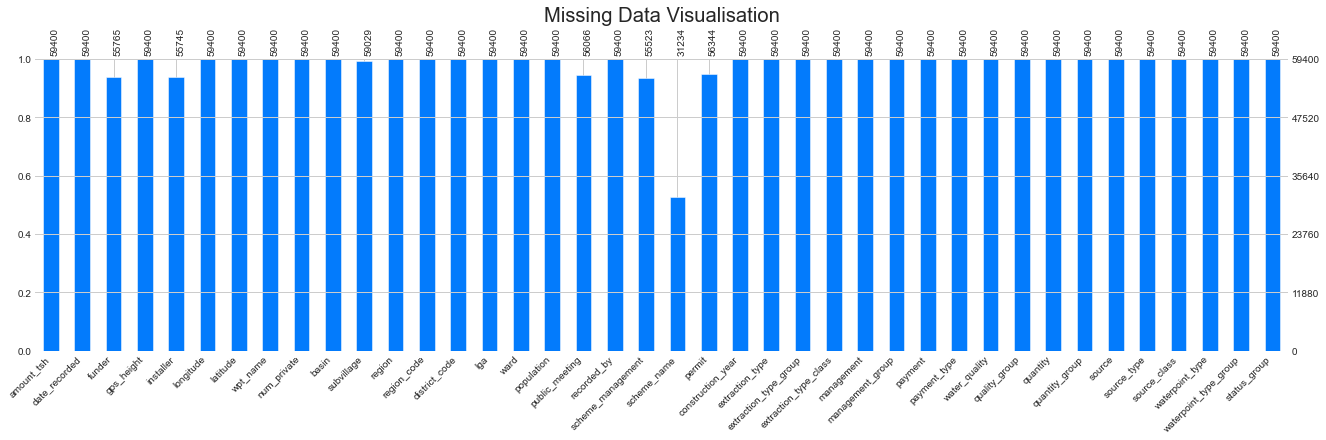

In [5]:
# Visualise the missing data in the DataFrame
msno.bar(data, figsize=(20, 5), fontsize=(10), color='#037bfc')
plt.title("Missing Data Visualisation")
plt.xticks(rotation = 90, fontsize=10);

The overall dataset does not contain much missing data. However, the `scheme_name` column is missing approximately half its data.

In [6]:
# Describe the numerical data
data.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


From the numerical column description, we can see that the data is 

## 3. Data Preparation
> This phase, which is often referred to as “data munging”, prepares the final data set(s) for modeling. It has five tasks:
> - Select Data
> - Clean Data
> - Construct Data
> - Integrate Data
> - Format Data
> - EDA

### 3.1 Select Data
> In this section, we determine which data sets will be used and document reasons for inclusion/exclusion.

The data selection will be influenced by the objectives and research questions stipulated in the business understanding phase

**Numerical Columns**

- `gps_height`
- `population`
- `amount_tsh`

**Categorical Columns**

- `funder`
- `installer`
- `basin`
- `subvillage`
- `region`
- `lga`
- `ward`
- `scheme_management`
- `permit`
- `construction_year`
- `extraction_type_class`
- `payment_type`
- `management_group`
- `quality_group`
- `quantity`
- `source_type`
- `waterpoint_type_group`
- `status_group`

In [7]:
# Create a new dataset
new_data = data.loc[:, ['amount_tsh','gps_height', 'population', 'funder', 'installer', 'basin', 'subvillage', 'region', 'lga', 'ward', 'scheme_management', 'permit', 'construction_year', 'extraction_type_class', 'payment_type', 'management_group', 'quality_group', 'quantity', 'source_type', 'waterpoint_type_group', 'status_group']]

new_data.reset_index(drop=True, inplace=True)
# Preview the new dataset
new_data.head()

,amount_tsh,gps_height,population,funder,installer,basin,subvillage,region,lga,ward,scheme_management,permit,construction_year,extraction_type_class,payment_type,management_group,quality_group,quantity,source_type,waterpoint_type_group,status_group
0,6000.0,1390,109,Roman,Roman,Lake Nyasa,Mnyusi B,Iringa,Ludewa,Mundindi,VWC,False,1999,gravity,annually,user-group,good,enough,spring,communal standpipe,functional
1,0.0,1399,280,Grumeti,GRUMETI,Lake Victoria,Nyamara,Mara,Serengeti,Natta,Other,True,2010,gravity,never pay,user-group,good,insufficient,rainwater harvesting,communal standpipe,functional
2,25.0,686,250,Lottery Club,World vision,Pangani,Majengo,Manyara,Simanjiro,Ngorika,VWC,True,2009,gravity,per bucket,user-group,good,enough,dam,communal standpipe,functional
3,0.0,263,58,Unicef,UNICEF,Ruvuma / Southern Coast,Mahakamani,Mtwara,Nanyumbu,Nanyumbu,VWC,True,1986,submersible,never pay,user-group,good,dry,borehole,communal standpipe,non functional
4,0.0,0,0,Action In A,Artisan,Lake Victoria,Kyanyamisa,Kagera,Karagwe,Nyakasimbi,NaN,True,0,gravity,never pay,other,good,seasonal,rainwater harvesting,communal standpipe,functional


### 3.2 Clean Data
> In this section we will be looking at the missing values in the dataset as well as the duplicate records in the dataset.

#### 3.2.1 Missing Values

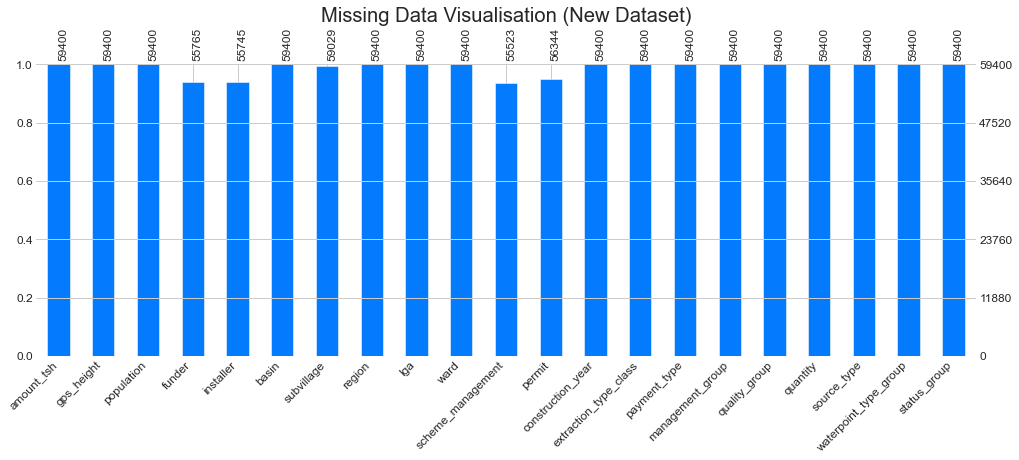

In [8]:
# We shall visualise the missing values in the new dataset
msno.bar(new_data, figsize=(15, 5), color='#037bfc', fontsize=12)
plt.title("Missing Data Visualisation (New Dataset)")
plt.xticks(rotation = 90);

From the visualisation above, we have identified the following columns to contain missing data:
- `funder`
- `installer`
- `subvillage`
- `scheme_management`
- `permit`

##### 3.2.1.1 `funder`

In [9]:
# Value counts of the 'funder' column
new_data['funder'].value_counts(dropna=False)

Government Of Tanzania    9084
NaN                       3635
Danida                    3114
Hesawa                    2202
Rwssp                     1374
                          ... 
Legeza Legeza                1
Rajab Seleman                1
Tlc/sorri                    1
Kopwe Khalifa                1
Yasi Naini                   1
Name: funder, Length: 1898, dtype: int64

The missing values in the `funder` column account for 6.12% of the values in the dataset. This is a fairly small amount of data, therefore, we can drop the missing values in the column.

In [10]:
# Drop the missing values
new_data.dropna(axis=0, subset=['funder'], inplace=True)

# New shape of the dataframe
print(new_data.shape)

# Check the value counts
new_data['funder'].value_counts(dropna=False)

(55765, 21)


Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Town Council                 1
Care/dwe                     1
Health  Ministry             1
Wards                        1
Bukwang Church Saints        1
Name: funder, Length: 1897, dtype: int64

##### 3.2.1.2 `installer`

In [11]:
# Value counts of the 'installer' column
print(f" Missing Values: {new_data['installer'].isna().sum()}")

# Check the value counts
new_data['installer'].value_counts(dropna=False)

 Missing Values: 73


DWE              17390
Government        1825
RWE               1206
Commu             1060
DANIDA            1050
                 ...  
Africaone Ltd        1
Shekhe               1
Icf                  1
WINAMU CO            1
TLC/community        1
Name: installer, Length: 2140, dtype: int64

The `installer` column only contains 73 missing values, this accounts for 0.13% of the total data. This is a very small percentage of the total data. Therefore, we can drop the records containing missing `installer` values.

In [12]:
# Drop the missing values
new_data.dropna(axis=0, subset=['installer'], inplace=True)

# New shape of the dataframe
print(new_data.shape)

# Check the value counts
new_data['installer'].value_counts(dropna=False)

(55692, 21)


DWE           17390
Government     1825
RWE            1206
Commu          1060
DANIDA         1050
              ...  
Pentecosta        1
Bao               1
Makoye            1
Kapelo            1
DWE & LWI         1
Name: installer, Length: 2139, dtype: int64

##### 3.2.1.3 `subvillage`

In [13]:
# Value counts of the 'subvillage' column
print(f" Missing Values: {new_data['subvillage'].isna().sum()}")

# Check the value counts
new_data['subvillage'].value_counts(dropna=False)

 Missing Values: 371


Shuleni        485
Madukani       484
Majengo        478
NaN            371
Kati           366
              ... 
Kwebulu          1
Ulogomani        1
Nyankeya         1
Kanango Juu      1
Sikimo           1
Name: subvillage, Length: 18286, dtype: int64

The subvillage column has 371 missing values. This accounts for 0.67% of the total data. Therefore, we can drop the missing values

In [14]:
# Drop the missing values
new_data.dropna(axis=0, subset=['subvillage'], inplace=True)

# New shape of the dataframe
print(new_data.shape)

# Check the value counts
new_data['subvillage'].value_counts(dropna=False)

(55321, 21)


Shuleni         485
Madukani        484
Majengo         478
Kati            366
Mtakuja         252
               ... 
Buyanja           1
Mangoma           1
Kisamuni          1
Nangali           1
Nyankunchi C      1
Name: subvillage, Length: 18285, dtype: int64

##### 3.2.1.4 `scheme_management`

In [15]:
# Value counts of the 'scheme_management' column
print(f" Missing Values: {new_data['scheme_management'].isna().sum()}")

# Check the value counts
new_data['scheme_management'].value_counts(dropna=False)

 Missing Values: 3804


VWC                 33565
WUG                  5164
NaN                  3804
Water authority      3061
WUA                  2656
Water Board          2530
Parastatal           1527
Private operator     1051
Company              1039
Other                 754
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

There are 3804 missing values in the scheme_management column. We can also see that there is a 'None' value, therefore, we shall be converting the missing values to 'None'.

In [16]:
# Replace the missing values with 'None
new_data['scheme_management'] = new_data['scheme_management'].replace(np.nan, 'None')

# Check the value counts
new_data['scheme_management'].value_counts(dropna=False)

VWC                 33565
WUG                  5164
None                 3805
Water authority      3061
WUA                  2656
Water Board          2530
Parastatal           1527
Private operator     1051
Company              1039
Other                 754
SWC                    97
Trust                  72
Name: scheme_management, dtype: int64

##### 3.2.1.5 `permit`

In [17]:
# Value counts of the 'permit' column
print(f" Missing Values: {new_data['permit'].isna().sum()}")

# Check the value counts
new_data['permit'].value_counts(dropna=False)

 Missing Values: 632


True     38104
False    16585
NaN        632
Name: permit, dtype: int64

There are 632 missing values in the `permit` column. We will be dropping the missing values as they only account for 1.14% of all the data in the column.

In [18]:
# Drop the missing values
new_data.dropna(axis=0, subset=['permit'], inplace=True)

# New shape of the dataframe
print(new_data.shape)

# Check the value counts
new_data['permit'].value_counts(dropna=False)

(54689, 21)


True     38104
False    16585
Name: permit, dtype: int64

We have a dataset does not contain any missing values

#### 3.2.2 Duplicated Data

We will be looking for data that has been imputted more than once.

In [19]:
# Find the duplicated records

duplicates  = new_data[new_data.duplicated()]

In [20]:
duplicates

,amount_tsh,gps_height,population,funder,installer,basin,subvillage,region,lga,ward,scheme_management,permit,construction_year,extraction_type_class,payment_type,management_group,quality_group,quantity,source_type,waterpoint_type_group,status_group
370,0.0,0,0,Government Of Tanzania,Government,Lake Victoria,Nyanza,Mwanza,Geita,Kalangalala,VWC,True,0,submersible,never pay,user-group,good,insufficient,borehole,communal standpipe,functional
1005,0.0,0,0,Kkkt_makwale,KKKT _ Konde and DWE,Lake Nyasa,Isimba,Mbeya,Kyela,Makwale,VWC,True,0,gravity,never pay,user-group,good,enough,spring,communal standpipe,functional
1606,0.0,0,0,Dwsp,DWE,Lake Victoria,Zagana,Shinyanga,Bariadi,Gamboshi,WUG,False,0,handpump,unknown,user-group,good,enough,shallow well,hand pump,functional
1748,0.0,0,0,Danida,Central government,Lake Nyasa,Malungo,Mbeya,Kyela,Mwaya,VWC,True,0,gravity,never pay,user-group,good,dry,spring,communal standpipe,non functional
1963,0.0,0,0,Kkkt_makwale,KKKT _ Konde and DWE,Lake Nyasa,Isimba,Mbeya,Kyela,Makwale,VWC,True,0,gravity,never pay,user-group,good,enough,spring,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59354,0.0,0,0,Md,DW,Lake Victoria,Kishoju 1,Kagera,Muleba,Nshamba,VWC,True,0,submersible,never pay,user-group,good,enough,spring,communal standpipe,non functional
59359,0.0,0,0,Hesawa,HESAWA,Lake Victoria,Mishenye,Kagera,Bukoba Rural,Buterankuzi,VWC,True,0,gravity,monthly,user-group,good,enough,river/lake,communal standpipe,functional
59369,0.0,0,0,Rc Church,RC Church,Lake Nyasa,Mjimwema,Mbeya,Mbeya Rural,Ulenje,VWC,False,0,gravity,on failure,user-group,good,enough,river/lake,communal standpipe,functional
59379,0.0,0,0,Do,DO,Lake Victoria,Kaluyango,Kagera,Muleba,Ikondo,VWC,True,0,gravity,never pay,user-group,good,enough,spring,communal standpipe,functional


Our dataset contains duplicated records, however, it is difficult to tell if the data is truly erroneous or whether multiple water wells were built at same time. Therefore, we wil not be dropping the duplicated values.

#### 3.2.3 Outliers

We will be performing outlier treatment on the numerical columns in out dataset. These are:
- `amount_tsh`
- `gps_height`
- `population`
- `construction_year`

The reason as to why we do outlier treatment is because:
- It increases the error variance and reduces the power of statistical tests
- If the outliers are non-randomly distributed, they can decrease normality
- They can bias or influence estimates that may be of substantive interest
- They can also impact the basic assumption of Regression, ANOVA and other statistical model assumptions.

In this case we will use boxplots to identify the outliers.

# identify the price outliers
plt.figure(figsize=(10,3))

sns.boxplot(x = '', data = new_data)

# Display the plot
plt.show()

<AxesSubplot:xlabel='amount_tsh'>

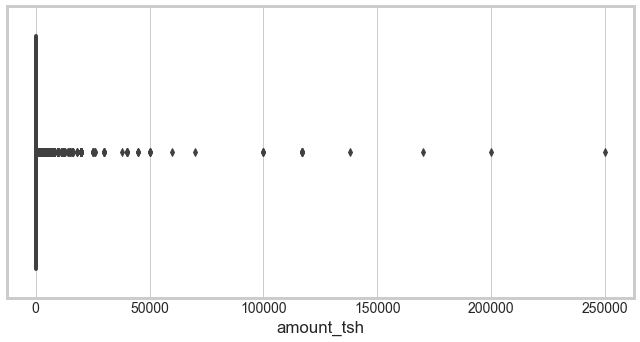

In [21]:
# identifying outliers in the amount_tsh column
plt.figure(figsize=(10,5))
sns.boxplot(x='amount_tsh', data= new_data)

<AxesSubplot:xlabel='gps_height'>

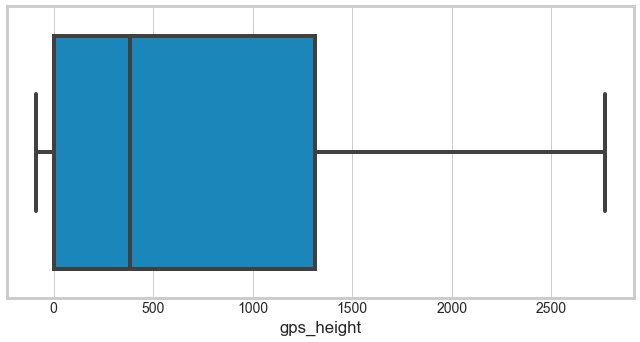

In [22]:
# visualizing a boxplot for "gps_height"
plt.figure(figsize=(10,5))
sns.boxplot(x='gps_height', data= new_data)

- There are no outliers in this column and most of the values seem to lie between 0 and 1300

<AxesSubplot:xlabel='population'>

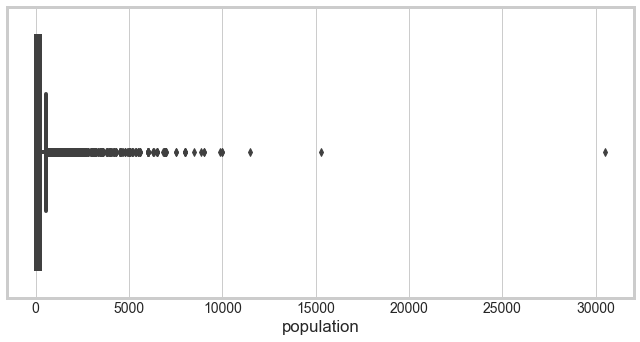

In [23]:
# population 
plt.figure(figsize=(10,5))
sns.boxplot(x='population', data= new_data)

- It seems like some regions have more people than others or this could suggest that a lot of the data has values of 0

- Having a lot of 0 values seems to have affected the data/ distribution.

<AxesSubplot:xlabel='construction_year'>

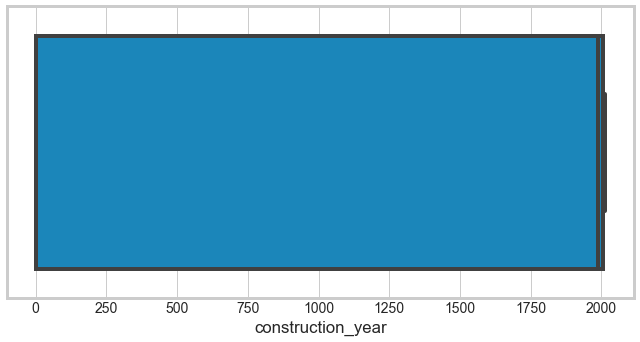

In [25]:
plt.figure(figsize=(10,5))
sns.boxplot(x='construction_year', data= new_data)